In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/test.csv


# House Price Prediction Notebook

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# LightGBM & CatBoost
import lightgbm as lgb
from catboost import CatBoostRegressor


In [3]:
train = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/train.csv")
test = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/test.csv")
sample = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (10000, 9)
Test shape: (3320, 8)


,id,area_type,availability,location,size,total_sqft,bath,balcony,price
0,0,type_I,Ready To Move,Banashankari 2 nd Stage,3 BHK,1030.0,2.0,2.0,77.25
1,1,type_I,Ready To Move,Balagere,2 BHK,1210.0,2.0,1.0,83.00
2,2,type_I,17-Oct,Banashankari Stage V,3 BHK,1540.0,3.0,2.0,48.51
3,3,type_I,Ready To Move,Thigalarapalya,3 BHK,1830.0,4.0,2.0,135.00
4,4,type_III,Ready To Move,arudi,3 Bedroom,NaN,2.0,0.0,80.00


# Dataset Overview



In [4]:
# Check data types
train.info()
# Descriptive statistics of numerical columns
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   area_type     10000 non-null  object 
 2   availability  10000 non-null  object 
 3   location      9999 non-null   object 
 4   size          9987 non-null   object 
 5   total_sqft    9967 non-null   float64
 6   bath          9936 non-null   float64
 7   balcony       9525 non-null   float64
 8   price         10000 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 703.3+ KB


,id,total_sqft,bath,balcony,price
count,10000.00000,9967.000000,9936.000000,9525.000000,10000.000000
mean,4999.50000,1570.095822,2.692029,1.585302,113.275879
std,2886.89568,1302.566836,1.274172,0.814347,151.802643
min,0.00000,1.000000,1.000000,0.000000,8.000000
25%,2499.75000,1100.000000,2.000000,1.000000,50.000000
50%,4999.50000,1279.000000,2.000000,2.000000,72.000000
75%,7499.25000,1682.500000,3.000000,2.000000,120.000000
max,9999.00000,52272.000000,18.000000,3.000000,3600.000000


In [5]:
if 'id' in train.columns:
    train.drop('id', axis=1, inplace=True)
if 'id' in test.columns:
    test.drop('id', axis=1, inplace=True)

# Handling Missing Values

In [6]:
if 'sqft_living' in train.columns and 'sqft_lot' in train.columns:
    train['total_area'] = train['sqft_living'] + train['sqft_lot']
    test['total_area'] = test['sqft_living'] + test['sqft_lot']

if 'year_built' in train.columns:
    train['age'] = 2025 - train['year_built']
    test['age'] = 2025 - test['year_built']

In [7]:
y = train['price']
X = train.drop('price', axis=1)

# Log-transform target for better regression
y_log = np.log1p(y)


# Handling Categorical Variables

In [8]:
categorical = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

# Align test columns with train
test = test.reindex(columns=X.columns, fill_value=0)

# Handling Skewed Features

In [9]:
from scipy.stats import skew

numeric_feats = X.select_dtypes(include=[np.number])
skewed_feats = numeric_feats.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 0.75].index

for col in skewed_cols:
    X[col] = np.log1p(X[col])
    test[col] = np.log1p(test[col])


# Scaling Numerical Features

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_scaled)
test_imputed = imputer.transform(test_scaled)

print(" Preprocessing done!")

 Preprocessing done!


# Visualizations

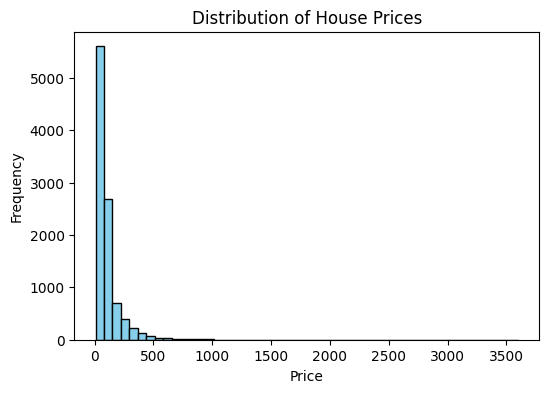

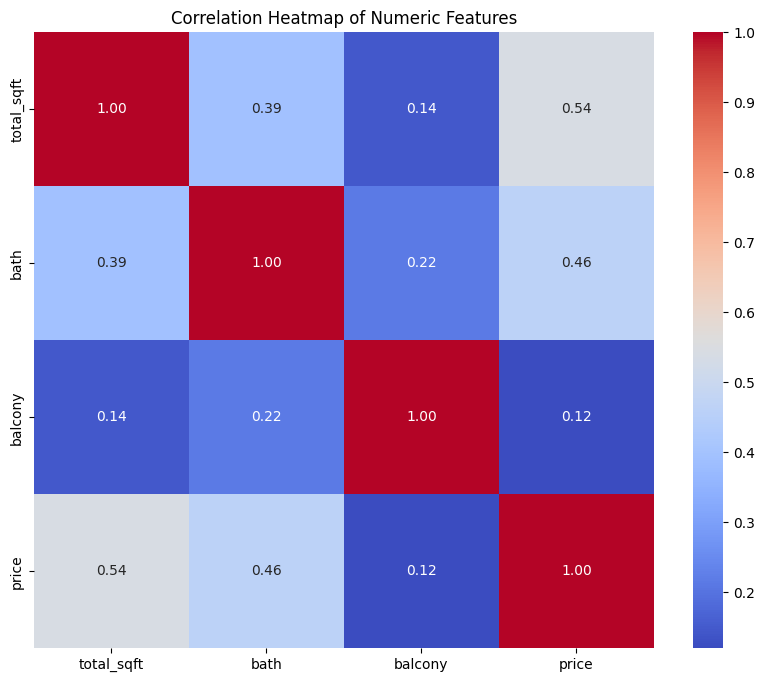

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1⯑ Histogram of target variable (price)
plt.figure(figsize=(6,4))
plt.hist(train['price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
# 2⯑ Correlation heatmap (numeric features only)
numeric_train = train.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_train.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y_log, test_size=0.2, random_state=42)

# Model Training

In [13]:
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
ridge_preds_valid = ridge.predict(X_valid)
ridge_rmse = np.sqrt(mean_squared_error(y_valid, ridge_preds_valid))
print(f"Ridge RMSE (log-target): {ridge_rmse:.4f}")

Ridge RMSE (log-target): 0.3307


In [14]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

lgb_preds_valid = lgb_model.predict(X_valid)
print(f"LightGBM RMSE (log-target): {np.sqrt(mean_squared_error(y_valid, lgb_preds_valid)):.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 130
[LightGBM] [Info] Start training from score 4.416407
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.310793	valid_1's rmse: 0.340547
[200]	training's rmse: 0.295683	valid_1's rmse: 0.337344
[300]	training's rmse: 0.286017	valid_1's rmse: 0.336516
Early stopping, best iteration is:
[278]	training's rmse: 0.287766	valid_1's rmse: 0.336347
LightGBM RMSE (log-target): 0.3363


In [15]:
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, eval_metric='RMSE',
                              random_seed=42, verbose=100)
cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
cat_preds_valid = cat_model.predict(X_valid)
print(f"CatBoost RMSE (log-target): {np.sqrt(mean_squared_error(y_valid, cat_preds_valid)):.4f}")

0:	learn: 0.6898042	test: 0.6941106	best: 0.6941106 (0)	total: 61.5ms	remaining: 1m 1s
100:	learn: 0.3441920	test: 0.3558133	best: 0.3558133 (100)	total: 674ms	remaining: 6s
200:	learn: 0.3274415	test: 0.3455167	best: 0.3455159 (198)	total: 1.26s	remaining: 4.99s
300:	learn: 0.3156914	test: 0.3382367	best: 0.3382367 (300)	total: 1.84s	remaining: 4.27s
400:	learn: 0.3062795	test: 0.3325151	best: 0.3325151 (400)	total: 2.42s	remaining: 3.62s
500:	learn: 0.2993433	test: 0.3287039	best: 0.3287039 (500)	total: 3s	remaining: 2.99s
600:	learn: 0.2930277	test: 0.3260061	best: 0.3260061 (600)	total: 3.6s	remaining: 2.39s
700:	learn: 0.2869483	test: 0.3231522	best: 0.3231522 (700)	total: 4.2s	remaining: 1.79s
800:	learn: 0.2826936	test: 0.3213462	best: 0.3213462 (799)	total: 4.79s	remaining: 1.19s
900:	learn: 0.2780281	test: 0.3192636	best: 0.3192636 (900)	total: 5.38s	remaining: 591ms
999:	learn: 0.2736783	test: 0.3173679	best: 0.3173679 (999)	total: 5.96s	remaining: 0us

bestTest = 0.317367904

# Ensemble Predictions

In [16]:
ensemble_valid = 0.2*ridge_preds_valid + 0.4*lgb_preds_valid + 0.4*cat_preds_valid
ensemble_rmse = np.sqrt(mean_squared_error(y_valid, ensemble_valid))
print(f"Ensemble RMSE (log-target): {ensemble_rmse:.4f}")

Ensemble RMSE (log-target): 0.3105


In [17]:
ridge.fit(X_imputed, y_log)
lgb_model = lgb.train(lgb_params, lgb.Dataset(X_imputed, label=y_log), num_boost_round=lgb_model.best_iteration)
cat_model.fit(X_imputed, y_log)

ridge_preds_test = ridge.predict(test_imputed)
lgb_preds_test = lgb_model.predict(test_imputed)
cat_preds_test = cat_model.predict(test_imputed)

# Weighted ensemble
ensemble_preds_test = 0.2*ridge_preds_test + 0.4*lgb_preds_test + 0.4*cat_preds_test

# Inverse log-transform
final_preds = np.expm1(ensemble_preds_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 155
[LightGBM] [Info] Start training from score 4.414894
0:	learn: 0.6909059	total: 7.2ms	remaining: 7.19s
100:	learn: 0.3448800	total: 638ms	remaining: 5.68s
200:	learn: 0.3292367	total: 1.26s	remaining: 5.02s
300:	learn: 0.3185015	total: 1.89s	remaining: 4.38s
400:	learn: 0.3101388	total: 2.51s	remaining: 3.74s
500:	learn: 0.3024449	total: 3.12s	remaining: 3.11s
600:	learn: 0.2965605	total: 3.74s	remaining: 2.48s
700:	learn: 0.2911528	total: 4.35s	remaining: 1.86s
800:	learn: 0.2861496	total: 4.97s	remaining: 1.23s
900:	learn: 0.2822814	total: 5.6s	remaining: 615ms
999:	learn: 0.2785621	total: 6.21s	remaining: 0us


In [18]:
submission = pd.DataFrame({
    'id': sample['id'] if 'id' in sample.columns else np.arange(len(final_preds)),
    'price': final_preds
})
submission.to_csv("submission.csv", index=False)
print("submission.csv saved successfully!")
submission.head()

submission.csv saved successfully!


,id,price
0,0,65.163472
1,1,103.849197
2,2,58.538174
3,3,151.197364
4,4,185.848993
